In [1]:
## PACKAGES


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import sys
sys.path.insert(1,'/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/examples/Scripts')
from pyDeepInsightv3 import ImageTransformer, CAMFeatureSelector

/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/shelia/anaconda3/envs/DInsight/lib/python3.8/site-packages/uma

In [2]:
##LOAD DATA
expr_file = r"../data/Survival_TCGA_VS_Desmd/filtered_desmd_average_ver1.csv"
expr1 = pd.read_csv(expr_file, encoding='utf-8', engine='python')
expr=expr1.transpose()
expr.columns=expr.iloc[0]
X_all = expr.iloc[1:,1:-1].values
X_all=X_all.astype(float)
days= expr.iloc[1:,-1].values
genes = expr.iloc[:,:-1].columns.to_numpy()


In [ ]:
# expr_file = r"../data/Survival_TCGA_VS_Desmd/filtered_desmd_average_ver1.csv"
# expr1 = pd.read_csv(expr_file, encoding='utf-8', engine='python')
# abc=expr1.transpose()
# abc.columns=abc.iloc[0]
# abc=abc.iloc[1:,0:]



In [ ]:
# for i in range(169,198,1):
#     if int(abc.iloc[i,12587])>=3000:
#         print(abc.index[i])

In [3]:
X=np.zeros((160,12586))
Y=[]
check=[]
j=0
for i in range(198):
    if days[i]<=1500:
        X[j]=X[j]+X_all[i]
        Y.append('short')
        check.append(days[i])
        j=j+1
    if days[i]>=3000:
        X[j]=X[j]+X_all[i]
        Y.append('long')
        check.append(days[i])
        j=j+1
    

In [ ]:
X.shape

Remove low variance data. In this case the bottom 30%.

In [4]:
var_filter = X.var(0) >= np.percentile(X.var(0), 10., method='nearest')

In [5]:
mms = MinMaxScaler()
X_norm = mms.fit_transform(X)
#X_test_norm = mms.transform(X_test)


Encode the classes

In [6]:
le = LabelEncoder()
y_enc = le.fit_transform(Y)
#y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_enc).size

In [7]:
num_classes

2

## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [8]:
reducer = umap.UMAP(
    #n_neighbors=40,
    n_components=2,
    min_dist=0.5,
    metric='cosine',
    n_jobs=-1,
    ##random_state=42
)

pixel_size = (32,32)

it = ImageTransformer(
    feature_extractor='kPCA',
    pixels=pixel_size)


printing original x_new  [[ 0.19306179 -0.12642172]
 [ 0.05481375 -0.04143745]
 [-0.00876029 -0.01273004]
 ...
 [ 0.19405013  0.01707698]
 [-0.11684887 -0.0045588 ]
 [-0.05963169 -0.03171617]]
printing chvertices


/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/examples/Scripts/pyDeepInsightv3/image_transformer.py:278: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


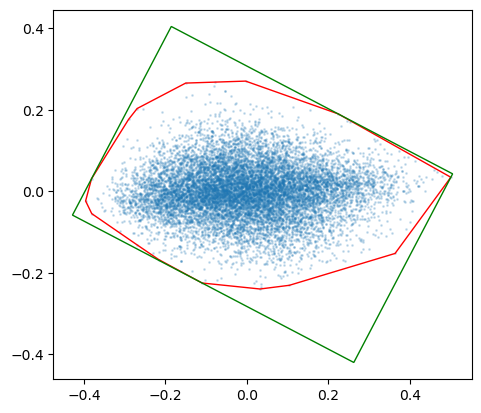

In [9]:
it.fit(X_norm, y=Y, plot=True)

In [8]:
##it.fit(X_norm, y=Y, plot=True)
from sklearn.decomposition import PCA, KernelPCA

kernel_pca = KernelPCA(
    n_components=2, kernel="rbf",gamma=.01)

X_kpca=kernel_pca.fit_transform(X_norm.transpose())

NameError: name 'X_norm' is not defined

In [9]:
from sklearn.decomposition import PCA, KernelPCA

In [48]:
X_kpca

array([[ 0.23689298, -0.15466461],
       [ 0.06827683, -0.05187344],
       [-0.01073654, -0.01551276],
       ...,
       [ 0.23864789,  0.02117359],
       [-0.14214261, -0.00545566],
       [-0.0740721 , -0.03917387]])

/tmp/ipykernel_347539/121769339.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  kernel_pca_proj_ax.scatter(X_kpca[:, 0], X_kpca[:, 1],s=1,cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
/tmp/ipykernel_347539/121769339.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  kernel_pca_proj_ax.scatter(X_kpca[:, 0], X_kpca[:, 1],s=1,cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)


Text(0.5, 1.0, 'Projection of testing data\n using kPCA')

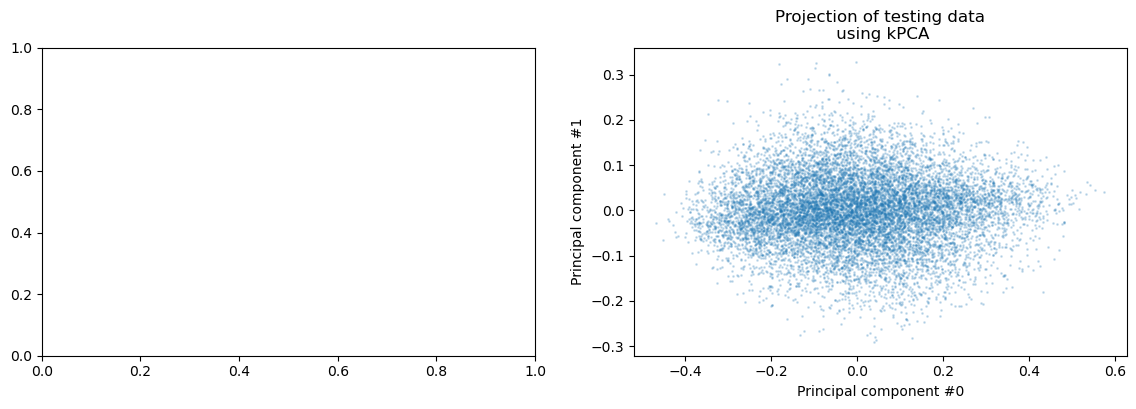

In [49]:
ig, (orig_data_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=2, figsize=(14, 4)
)

kernel_pca_proj_ax.scatter(X_kpca[:, 0], X_kpca[:, 1],s=1,cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
kernel_pca_proj_ax.set_title("Projection of testing data\n using kPCA")



In [ ]:
X_img = it.transform(X_norm)
#X_test_img = it.transform(X_test_norm)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23, stratify=Y)

var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = timm.create_model('resnet26d', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)

batch_size=50
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])



In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), 
    lr=1e-02,
    momentum=0.9,
)

In [14]:
val=dict()
for g in range(1,300,10):
    g=g/100
    print(g)
    reducer=KernelPCA(n_components=2, kernel='rbf',gamma=g)

    pixel_size = (224,224)

    it = ImageTransformer(
        feature_extractor=reducer,
        pixels=pixel_size)
    
    it.fit(X_train_norm, y=y_train, plot=False)
    X_train_img = it.transform(X_train_norm)
    X_test_img = it.transform(X_test_norm)

    #defing the data loader
    X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
    y_train_tensor = torch.from_numpy(y_train_enc).to(device)
    trainset = TensorDataset(X_train_tensor, y_train_tensor)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
    y_test_tensor = torch.from_numpy(y_test_enc).to(device)
    testset = TensorDataset(X_test_tensor, y_test_tensor)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


    ##training the data using resnet:
    net.train()
    for epoch in range(20):
        for i, (inputs, labels) in enumerate(trainloader):
            clear_output(wait=True)
            #display(f"Epoch {epoch:03d}, batch {i:03d}")
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

    ###testing the data
    test_predicted = np.empty(0)
    test_true = np.empty(0)

    net.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
            test_predicted = np.append(test_predicted, pred)
            test_true = np.append(test_true, labels.cpu().detach().numpy())

    #print(f"The test accuracy with gamma value {g:.2f} was {accuracy_score(test_predicted, test_true):.3f}")
    ac=round(accuracy_score(test_predicted, test_true))
    val[g]=ac

            
        

2.91


In [15]:
val

{0.01: 1,
 0.11: 1,
 0.21: 1,
 0.31: 1,
 0.41: 1,
 0.51: 1,
 0.61: 1,
 0.71: 1,
 0.81: 0,
 0.91: 1,
 1.01: 0,
 1.11: 1,
 1.21: 1,
 1.31: 1,
 1.41: 1,
 1.51: 1,
 1.61: 1,
 1.71: 0,
 1.81: 1,
 1.91: 0,
 2.01: 0,
 2.11: 1,
 2.21: 1,
 2.31: 1,
 2.41: 0,
 2.51: 1,
 2.61: 1,
 2.71: 0,
 2.81: 1,
 2.91: 1}